# Initialisation et importation des données


On commence par initialiser les environnements d'exécution et importer les modules nécessaires de Pyspark.

> Bloc en retrait



In [0]:
import tensorflow as tf


from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.3.2/spark-2.3.2-bin-hadoop2.7.tgz
!tar xf spark-2.3.2-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install h5py
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.2-bin-hadoop2.7"
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pyspark
##Liste
from numpy import array
##Temps
import time
##Row and Vector
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
##Hachage et vectorisation
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF
##Regression logistique
from pyspark.ml.classification import LogisticRegression
##Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier
##Random Forest
from pyspark.ml.classification import RandomForestClassifier 
##Pour la création des DataFrames
from pyspark.sql import SQLContext
from pyspark.sql.types import *

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


On définit à présent notre environnement Spark. Nous avons essayé de modifier le nombre d'exécuteurs et la mémoire alloué, mais il semble que ces tentatives aient échoué.
On importe également notre fichier train et on vérifie que les données sont bien lisibles.

In [0]:
from pyspark.sql import SparkSession
from pyspark import SparkContext


import h5py 


conf1 = pyspark.SparkConf().setAll([('spark.executor.cores', '3'), ('spark.cores.max', '6'),('spark.driver.memory','1g')])
spark = SparkSession.builder.config(conf=conf1).config('yarn-client','pyspark').getOrCreate()

path='drive/My Drive/PLP project/Dreem/train.h5'


def readchunk(v):
    empty = h5py.File(path)
    return empty['eeg_2'][v,:]

sc=spark.sparkContext
foo = sc.parallelize(range(0,38000)).map(lambda v: (v,readchunk(v)))
foo.take(10)

[(0, array([12.81139748, 10.23868508,  9.25786068, ...,  2.35681373,
          4.81336897,  7.11477912])),
 (1, array([-20.99636609, -18.84257191, -19.55878205, ...,  26.2932541 ,
          32.63625664,  10.05042665])),
 (2, array([11.57101396,  9.46511331, 12.60972313, ...,  3.73292468,
          0.01623215, 11.22593731])),
 (3, array([-20.99755238, -19.37701693, -17.63103769, ...,   0.65508617,
          -0.2470895 ,  -1.94179311])),
 (4, array([14.19204831,  6.74260088,  8.38859394, ..., -0.12136205,
          0.89630593, -1.85563248])),
 (5, array([ 64.30887226,  39.26232181,  25.416105  , ..., -13.30692909,
           2.52159587,  11.34789506])),
 (6, array([ 9.28125009,  9.00848932, 11.51309241, ..., -1.16279021,
          4.69858697, -1.42872467])),
 (7, array([-9.35299895, -3.08224844,  5.30605955, ..., 10.53458358,
          2.09383253, -3.39830825])),
 (8, array([-11.17110442,  -6.05354225,  -4.43402715, ...,   2.2582559 ,
           3.50654023,   4.1204217 ])),
 (9, array([1

# Filtrage et Calcul des features


On commence par créer une fonction qui va permettre de filtrer chacun des signaux selon des bandes de fréquences pertinentes selon les études scientifiques déjà menées sur les ondes EEG de notre cerveau.

In [0]:

#b, a = butter_bandpass(lowcut, highcut, fs, order=order)
from scipy.signal import butter, lfilter
sqlContext=SQLContext(spark)

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
  
BDelta=butter_bandpass(0.01,4,50,order=3)
BTheta=butter_bandpass(4,6.5,50,order=3)
BAlpha=butter_bandpass(6.5,11,50,order=3)
BBeta=butter_bandpass(11,20,50,order=3)
BGamma=butter_bandpass(20,24,50,order=3)

test=foo.filter(lambda x : x[0]==12).map(lambda x : x[1])

**Calcul des features**

Afin de limiter les temps de calcul, on va ici s'intéresser à 3 features simples pour chacun des signaux filtrés. Pour les données issues des accéléromètres, on calculera la moyenne et l'écart-type.

In [0]:
def Entropy(x):
  return(np.sum(x*x*np.log(abs(x))).astype(type('float', (float,), {})))
def Energy(x):
  return(np.sum(np.sqrt(x*x)).astype(type('float', (float,), {})))
def Ecart_type(x):
  return(np.mean((x-np.mean(x)*(x-np.mean(x)))).astype(type('float', (float,), {})))


Ici on crée nos RDD à partir des données extraites.

In [0]:
import numpy as np
path='drive/My Drive/PLP project/Dreem/train.h5'
def readchunk1(v):
    empty = h5py.File(path)
    return empty['eeg_1'][v,:]
def readchunk2(v):
    empty = h5py.File(path)
    return empty['eeg_2'][v,:]

def readchunkx(v):
    empty = h5py.File(path)
    return empty['accelerometer_x'][v,:]

def readchunky(v):
    empty = h5py.File(path)
    return empty['accelerometer_y'][v,:]

def readchunkz(v):
    empty = h5py.File(path)
    return empty['accelerometer_z'][v,:]
  
EEG1 = sc.parallelize(range(0,100)).map(lambda v: (v,readchunk1(v)))
ACCX=sc.parallelize(range(0,100)).map(lambda v: (v,readchunkx(v)))
ACCY=sc.parallelize(range(0,100)).map(lambda v: (v,readchunky(v)))
ACCZ=sc.parallelize(range(0,100)).map(lambda v: (v,readchunkz(v)))




Sur chacun des RDD, on va pouvoir appliquer nos filtres et nos fonctions, nous permettant ainsi d'obtenir des features pertinents.

In [0]:
D1=EEG1.map(lambda v : lfilter(BDelta[0], BDelta[1],v[1].reshape(1500,)))
EntropyD1=D1.map(lambda x : Entropy(x.reshape(1500,)))
EnergyD1=D1.map(lambda x : Energy(x.reshape(1500,)))
ECD1=D1.map(lambda x : Ecart_type(x.reshape(1500,)))

T1=EEG1.map(lambda v : lfilter(BTheta[0], BTheta[1],v[1].reshape(1500,)))
EntropyT1=T1.map(lambda x : Entropy(x.reshape(1500,)))
EnergyT1=T1.map(lambda x : Energy(x.reshape(1500,)))
ECT1=T1.map(lambda x : Ecart_type(x.reshape(1500,)))

A1=EEG1.map(lambda v : lfilter(BAlpha[0], BAlpha[1],v[1].reshape(1500,)))
EntropyA1=A1.map(lambda x : Entropy(x.reshape(1500,)))
EnergyA1=A1.map(lambda x : Energy(x.reshape(1500,)))
ECA1=A1.map(lambda x : Ecart_type(x.reshape(1500,)))

G1=EEG1.map(lambda v : lfilter(BGamma[0], BGamma[1],v[1].reshape(1500,)))
EntropyG1=G1.map(lambda x : Entropy(x.reshape(1500,)))
EnergyG1=G1.map(lambda x : Energy(x.reshape(1500,)))
ECG1=G1.map(lambda x : Ecart_type(x.reshape(1500,)))

Mx=ACCX.map(lambda v : np.mean(v[1].reshape(300,)))
My=ACCY.map(lambda v : np.mean(v[1].reshape(300,)))
Mz=ACCZ.map(lambda v : np.mean(v[1].reshape(300,)))
Sx=ACCX.map(lambda v : Ecart_type(v[1].reshape(300,)))
Sy=ACCY.map(lambda v : Ecart_type(v[1].reshape(300,)))
Sz=ACCZ.map(lambda v : Ecart_type(v[1].reshape(300,)))


Ici on importe la colonne des labels, qui est déjà sous forme de Dataframe.

In [0]:
import numpy as np 
file='drive/My Drive/PLP project/Dreem/train_y.csv'
lab=sqlContext.read.format('com.databricks.spark.csv').options(delimiter=",").load(file, header = True)

from pyspark.sql.functions import col

Sleep_stage=lab.select('sleep_stage')

L'idée ici est de transformer toutes nos features (sous forme de RDDs) en un seul DataFrame. Pour cela on indexe chacun des features (avec un numéro de ligne) afin de pouvoir réaliser des jointures simples.
Hélas cette méthode échoue en raison d'un manque de ressources...

In [0]:
import pandas as pd
from pyspark.sql.functions import lit
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import FloatType
liste=[Sleep_stage,EntropyD1, EntropyT1,EntropyA1,EntropyG1,EnergyD1,EnergyT1,EnergyA1,EnergyG1,ECD1,ECT1,ECA1,ECG1,Mx,My,Mz,Sx,Sy,Sz]
features=['sleep_stage','EntropyD1', 'EntropyT1','EntropyA1','EntropyG1','EnergyD1','EnergyT1','EnergyA1','EnergyG1','ECD1','ECT1','ECA1','ECG1','Mx','My','Mz','Sx','Sy','Sz']



dataframes=[Sleep_stage]
k=1

for x in liste[1:]:
  dataframes.append(sqlContext.createDataFrame(x,FloatType()).toDF(features[k]))
  k+=1
  
F=[]
for d in dataframes:
  e=d.withColumn("id", monotonically_increasing_id()) 
  F.append(e)

df=F[0]

df=df.withColumn("Sleep_stage",df["sleep_stage"].cast(FloatType()))
F.pop(0)
for d in F:
  newd=df
  df=newd.join(d,'id')
  
df=df.drop("id")

#df.show()



On doit ainsi changer notre fusil d'épaule, et pour cela on choisit une méthode plus "artisanale", qui consiste à calculer les features sur chacune des lignes une par une.
On réalise à chaque fois une union entre la ligne calculée et les précédentes. Cette méthode s'avère très lente.

In [0]:
import numpy as np 
import time
tmps1=time.clock()

EntropyD1=[]
EntropyT1=[]
EntropyA1=[]
EntropyG1=[]
EnergyD1=[]
EnergyT1=[]
EnergyA1=[]
EnergyG1=[]
ECD1=[]
ECT1=[]
ECA1=[]
ECG1=[]
Mx=[]
My=[]
Mz=[]
Sx=[]
Sy=[]
Sz=[]


for i in range(200):
  if i%10==0:
    print(i)
  v1=EEG1.filter(lambda x : x[0]==i).map(lambda x : x[1]).take(1)
  
  vx=ACCX.filter(lambda x : x[0]==i).map(lambda x : x[1]).take(1)
  vy=ACCY.filter(lambda x : x[0]==i).map(lambda x : x[1]).take(1)
  vz=ACCZ.filter(lambda x : x[0]==i).map(lambda x : x[1]).take(1)
  
  d1 = lfilter(BDelta[0], BDelta[1],v1)
  t1=  lfilter(BTheta[0], BTheta[1],v1)
  a1 = lfilter(BAlpha[0], BAlpha[1],v1)
  g1 = lfilter(BGamma[0], BGamma[1],v1)
  
  
  labv=lab.select('sleep_stage').where(col("id").isin({i}))
  label=int(np.array(labv.take(1))[0,0])

  
  from pyspark.sql.types import *
  
  
  #
  liste=[(label,Entropy(d1), Entropy(t1), Entropy(a1), Entropy(g1), Energy(d1),Energy(t1) , Energy(a1),Energy(g1), Ecart_type(d1),Ecart_type(t1),Ecart_type(a1),Ecart_type(g1),np.mean(vx),np.mean(vy),np.mean(vz),Ecart_type(vx),Ecart_type(vy),Ecart_type(vz))]
  #rdd.take(10)
  from pyspark.sql.types import FloatType
  liste=np.asarray(liste)
  liste=liste.tolist()
  #rdd = sc.parallelize(liste)
  
  #dfu=sqlContext.createDataFrame(rdd, ["EntropyD1", "EntropyT1","EntropyA1","EntropyG1","EnergyD1","EnergyT1","EnergyA1","EnergyG1","ECD1","ECT1","ECA1","ECG1","Mx","My","Mz","Sx","Sy","Sz"])
  features=['Sleep_stage','EntropyD1', 'EntropyT1','EntropyA1','EntropyG1','EnergyD1','EnergyT1','EnergyA1','EnergyG1','ECD1','ECT1','ECA1','ECG1','Mx','My','Mz','Sx','Sy','Sz']
 
  #dfu=sqlContext.createDataFrame(liste,schema)
  
  dfu=sqlContext.createDataFrame(liste,features, FloatType())
  if i!=0:
    df=df.union(dfu)
  else :
    df=dfu
  
tmps2=time.clock()
print(tmps2-tmps1)
  

0
10
20


**Matrice de corrélation**

L'idée ici est de réduire le nombre de features pour accélérer le temps de calcul. Pour cela on affiche les couples de features ayant un score supérieur à 0.95

In [0]:
from pyspark.ml.stat import Correlation
features=["Sleep_stage","EntropyD1", "EntropyT1","EntropyA1","EntropyG1","EnergyD1","EnergyT1","EnergyA1","EnergyG1","ECD1","ECT1","ECA1","ECG1","Mx","My","Mz","Sx","Sy","Sz"]
feat = df.rdd.map(lambda row: row[0:])

corr_mat=Statistics.corr(feat, method="pearson")

M=[]
for i in range(19):
  for j in range(i+1,19):
    if corr_mat[i,j]>0.95 and i!=j:
      M.append((features[i],features[j]))

print(M)

**Fichier issu du calcul Python**
Pour comparer les performances de l'apprentissage, on va prendre le dataframe calculé par Python comportant toutes les lignes (environ 38000). Il serait en effet peu intéressant de lancer des algorithmes de Machine Learning sur un nombre faible de données.

In [0]:
import numpy as np 
file='drive/My Drive/PLP project/Dreem/data_dreem.csv'
df=sqlContext.read.format('com.databricks.spark.csv').options(delimiter=",").load(file, header = True)
for col in df.columns:
  df=df.withColumn(str(col),df[col].cast(FloatType()))
df.schema

# Construction du modèle et Apprentissage

On commence par utiliser des fonctions d'indexation, d'encodage et d'assemblage sur notre DataFrame afin de pouvoir tester des classifiers.

In [0]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')
  
tmps1=time.clock()  
catcols = []

num_cols = [df.columns[i] for i in range(len(df.columns)) if df.columns[i]!="labels"]

labelCol = "labels"

data = get_dummy(df,catcols,num_cols,labelCol)
c=data.count()

In [0]:
from pyspark.ml.feature import VectorIndexer
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.

featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(data)
featureIndexer.transform(data).show(5, True)

In [0]:
from pyspark.ml.feature import StringIndexer
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(data)
labelIndexer.transform(data).show(5, True)

Pour finir, on lance le modèle sur un RandomForestClassifier qui s'est avéré le plus efficace pour nos données. On divise le trainingSet par tranches de 10% afin de pouvoir mesurer l'évolution de l'erreur et du temps de calcul en fonction de la taille de la base d'entraînement. 

In [0]:
from pyspark.ml.feature import IndexToString, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

temps=[]
test_err=[]
taille=[]
(data_bis,testData)=data.randomSplit([0.8,0.2])
for i in range(1,9):
  print(i)
  
  (trainingData_bis, testData_bis) =data_bis.randomSplit([i*0.1,1-i*0.1])

  
  
  rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=50,maxDepth=20)
  # Convert indexed labels back to original labels.
  labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                                 labels=labelIndexer.labels)
  # Chain indexers and tree in a Pipeline
  pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])
  # Train model.  This also runs the indexers.
  tmps1=time.time()
  model = pipeline.fit(trainingData_bis)
  tmps2=time.time()
  # Make predictions.
  predictions = model.transform(testData)
  # Select (prediction, true label) and compute test error
  evaluator = MulticlassClassificationEvaluator(
      labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
  test_err.append(evaluator.evaluate(predictions))
  taille.append(trainingData_bis.count())
  
  
  temps.append(tmps2-tmps1)

In [0]:

import matplotlib.pyplot as plt
plt.plot(taille,temps)
plt.title("Le temps d'apprentissage en fonction de la taille d'échantillon")
plt.ylabel('Les temps')
plt.xlabel("La taille de l'échantillon")


Text(0.5, 0, "La taille de l'échantillon")

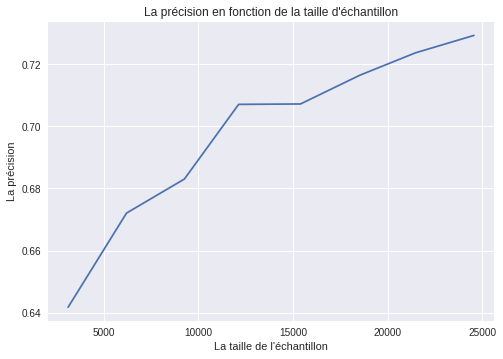

In [0]:
import matplotlib.pyplot as plt
plt.plot(taille,test_err)
plt.title("La précision en fonction de la taille d'échantillon")
plt.ylabel('La précision')
plt.xlabel("La taille de l'échantillon")

On obtient une précision équivalente à celle obtenue sur Python. Les temps de calcul sont par contre au moins doublés.